# Welcome

This notebook serves as an example to how we can determine the internal accessibility of neighbourhoods in relation to Low Traffic Neighbourhoods. Any issues, please contact me at b8008458@newcastle.ac.uk!

We begin with importing the necessary libraries. There should be a .yml file on the GitHub repository which can be used to set up the correct environment. We also update OSMNx to ensure all the OSM tags we need are avaiable and ready. 

In [6]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
import statistics
from shapely.ops import unary_union
import random

We can now import the neighbourhoods that we are going to use in this analysis. You can use your own neighbourhood boundaries if you have them. We will use the ones created in the previous notebook. We also need to set our study area boundary:

In [7]:
# set place
place = "Newcastle Upon Tyne, United Kingdom"

In [8]:
# Path to your GeoPackage file
file_path = r'C:\Users\b8008458\Documents\scratch_space\neighbourhoods.gpkg'

In [9]:
# Read GeoPackage 
neighbourhoods = gpd.read_file(file_path, driver="GPKG")

# check neighbourhoods are correct by viewing them on a map:
neighbourhoods.explore()

In [10]:
# boundary
boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)

We need the walking, driving and complete street networks for this section of analysis. We use OpenStreetMap data for our street networks. The common nodes between the walking and driving networks are found to ensure we have viable origins and destiniations for our accessiablity analysis. There is also a final cleaning of the the neighbourhoods to ensure that we can assess the neighbourhood accessiablity of all areas.

In [11]:
## get street networks for walking and driving

# reset boundary_buffered crs for passing to OSM
boundary_buffered_4326 = boundary_buffered.to_crs('4326')

# get street networks

all_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='all', simplify=False)
walk_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='walk', simplify=True)
drive_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='drive', simplify=False)

all_edges = ox.graph_to_gdfs(all_streets, nodes=False, edges=True)
all_nodes = ox.graph_to_gdfs(all_streets, nodes=True, edges=False)

walk_edges = ox.graph_to_gdfs(walk_streets, nodes=False, edges=True)
walk_nodes = ox.graph_to_gdfs(walk_streets, nodes=True, edges=False)

drive_edges = ox.graph_to_gdfs(drive_streets, nodes=False, edges=True)
drive_nodes = ox.graph_to_gdfs(drive_streets, nodes=True, edges=False)


## find the common nodes between networks 

# this ensures that shortest paths between points should always be able to be calculated
common_nodes = drive_nodes.merge(walk_nodes, on='osmid', suffixes=('_drive', '_walk'))
common_nodes_gdf = gpd.GeoDataFrame(common_nodes, geometry='geometry_drive')
common_nodes_gdf.explore()



## filter neighbourhoods to only locations with more than 1 intersection (1 or fewer intersections indicates that all travel modes will be the same)

# reset neighbourhoods crs
neighbourhoods = neighbourhoods.to_crs('4326')

# Spatial join to count points within each neighborhood
spatial_join = gpd.sjoin(neighbourhoods, common_nodes_gdf, how='left', op='contains')

# Group by 'ID' and count the points within each neighborhood
point_counts = spatial_join.groupby('ID').size().reset_index(name='point_count')

# Filter out neighborhoods with 1 or 0 points
filtered_neighbourhood_ids = point_counts[point_counts['point_count'] > 1]['ID']

neighbourhoods= neighbourhoods[neighbourhoods['ID'].isin(filtered_neighbourhood_ids)]


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


To measure the accessiablity of a neighbourhood, we compare the shortest path distances of walking against driving. The shortest distances are found in this example between 5 random nodes within each neighbourhood to 5 other random common nodes within each respective neighbourhood. In more detailed analysis, a greater number of nodes should be used. This provides a measure of permiablity within the neighbourhood. A large differance in shortest path distance indicates high permiablity for walking, and therefore a LTN is more likely.

In [12]:
## random to random for shortest distance calculations

# begin function 
def calculate_distance_stats_from_points(points_gdf, network):
    all_pairs_shortest_paths = {}
    points_osmids = points_gdf.index.tolist()  # Assuming the 'osmid' is the index in the GeoDataFrame

    if len(points_osmids) <= 5:
        # If there are less than 5 nodes, calculate all to all
        for start_node in points_osmids:
            shortest_paths = {}
            try:
                for end_node in points_osmids:
                    if start_node != end_node:
                        distance = nx.shortest_path_length(network, start_node, end_node, weight='length')
                        shortest_paths[end_node] = distance
                all_pairs_shortest_paths[start_node] = shortest_paths
            except nx.NetworkXNoPath:
                # If no path is found, continue to the next iteration
                continue
    else:
        # Randomly select 5 nodes for both start and end
        start_nodes = random.sample(points_osmids, 5)
        end_nodes = random.sample(points_osmids, 5)

        for start_node in start_nodes:
            shortest_paths = {}
            try:
                for end_node in end_nodes:
                    if start_node != end_node:
                        distance = nx.shortest_path_length(network, start_node, end_node, weight='length')
                        shortest_paths[end_node] = distance
                all_pairs_shortest_paths[start_node] = shortest_paths

            except nx.NetworkXNoPath:
                # If no path is found, continue to the next iteration
                continue

    distances = [length for paths in all_pairs_shortest_paths.values() for length in paths.values()]

    mean_distance = statistics.mean(distances)
    median_distance = statistics.median(distances)
    min_distance = min(distances)
    max_distance = max(distances)
    distance_range = max_distance - min_distance
    total_distance = sum(distances)

    return {
        "mean_distance": mean_distance,
        "median_distance": median_distance,
        "min_distance": min_distance,
        "max_distance": max_distance,
        "distance_range": distance_range,
        "total_distance": total_distance
    }

results = []

for index, row in neighbourhoods.iterrows():
    neighbourhood = neighbourhoods.loc[[index]]
    print("Starting index number", index)

    ## get neighbourhood boundary and neighbourhood boundary buffer
    # set crs
    neighbourhood = neighbourhood.to_crs('27700')
    # create a buffer neighbourhood
    neighbourhood_buffer = neighbourhood['geometry'].buffer(15)
    # convert back to a geodataframe (for later on)
    neighbourhood_buffer = gpd.GeoDataFrame(geometry=neighbourhood_buffer)
    # reset crs
    neighbourhood, neighbourhood_buffer = neighbourhood.to_crs('4326'), neighbourhood_buffer.to_crs('4326')


    ## get nodes which can be driven to and walked to within area
    neighbourhood_nodes = gpd.clip(common_nodes_gdf, neighbourhood_buffer)

    ## get length of total edges within the neighbourhood
    edges_within_neighbourhood = gpd.sjoin(all_edges, neighbourhood, how="inner", op="intersects")
    total_length = edges_within_neighbourhood['length'].sum()


    ## calculate neighbourhood distance stats for walking and driving
    walk_stats = calculate_distance_stats_from_points(neighbourhood_nodes, walk_streets)
    drive_stats = calculate_distance_stats_from_points(neighbourhood_nodes, drive_streets)


    ## Add the statistics to the GeoDataFrame
    neighbourhood['walk_mean_distance'] = walk_stats['mean_distance']
    neighbourhood['walk_median_distance'] = walk_stats['median_distance']
    neighbourhood['walk_min_distance'] = walk_stats['min_distance']
    neighbourhood['walk_max_distance'] = walk_stats['max_distance']
    neighbourhood['walk_distance_range'] = walk_stats['distance_range']
    neighbourhood['walk_total_distance'] = walk_stats['total_distance']

    neighbourhood['drive_mean_distance'] = drive_stats['mean_distance']
    neighbourhood['drive_median_distance'] = drive_stats['median_distance']
    neighbourhood['drive_min_distance'] = drive_stats['min_distance']
    neighbourhood['drive_max_distance'] = drive_stats['max_distance']
    neighbourhood['drive_distance_range'] = drive_stats['distance_range']
    neighbourhood['drive_total_distance'] = drive_stats['total_distance']

    ## Store statistics along with neighborhood ID or other identifying information
    result = {
        'neighbourhood_id': neighbourhood['ID'].iloc[0],  # Assuming you have an ID column
        'walk_mean_distance': walk_stats['mean_distance'],
        'walk_median_distance': walk_stats['median_distance'],
        'walk_total_distance': walk_stats['total_distance'],
        

        'drive_mean_distance': drive_stats['mean_distance'],
        'drive_median_distance': drive_stats['median_distance'],
        'drive_total_distance': drive_stats['total_distance'],

        'total_edge_length': total_length
    }

    print("Polygon", index, "processed, moving to next")
    results.append(result)

## Convert the results to a new dataframe
results_df = pd.DataFrame(results)


 

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 0
Polygon 0 processed, moving to next
Starting index number 1
Polygon 1 processed, moving to next
Starting index number 2


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 2 processed, moving to next
Starting index number 3
Polygon 3 processed, moving to next
Starting index number 4


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 4 processed, moving to next
Starting index number 5
Polygon 5 processed, moving to next
Starting index number 6


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 6 processed, moving to next
Starting index number 7
Polygon 7 processed, moving to next
Starting index number 8


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 8 processed, moving to next
Starting index number 9


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 9 processed, moving to next
Starting index number 10
Polygon 10 processed, moving to next
Starting index number 11


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 11 processed, moving to next
Starting index number 12
Polygon 12 processed, moving to next
Starting index number 13


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 13 processed, moving to next
Starting index number 14


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 14 processed, moving to next
Starting index number 18


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 18 processed, moving to next
Starting index number 19


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 19 processed, moving to next
Starting index number 20
Polygon 20 processed, moving to next
Starting index number 21


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 21 processed, moving to next
Starting index number 22
Polygon 22 processed, moving to next
Starting index number 23


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 23 processed, moving to next
Starting index number 24
Polygon 24 processed, moving to next
Starting index number 25


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 25 processed, moving to next
Starting index number 26


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 26 processed, moving to next
Starting index number 27


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 27 processed, moving to next
Starting index number 29
Polygon 29 processed, moving to next
Starting index number 32


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 32 processed, moving to next
Starting index number 33
Polygon 33 processed, moving to next
Starting index number 34


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 34 processed, moving to next
Starting index number 35


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 35 processed, moving to next
Starting index number 36


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 36 processed, moving to next
Starting index number 37


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 37 processed, moving to next
Starting index number 38


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 38 processed, moving to next
Starting index number 39
Polygon 39 processed, moving to next
Starting index number 40


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 40 processed, moving to next
Starting index number 41
Polygon 41 processed, moving to next
Starting index number 42


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 42 processed, moving to next
Starting index number 43


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 43 processed, moving to next
Starting index number 44
Polygon 44 processed, moving to next
Starting index number 45


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 45 processed, moving to next
Starting index number 46
Polygon 46 processed, moving to next
Starting index number 47


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 47 processed, moving to next
Starting index number 48


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 48 processed, moving to next
Starting index number 49


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 49 processed, moving to next
Starting index number 50
Polygon 50 processed, moving to next
Starting index number 51


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 51 processed, moving to next
Starting index number 52


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 52 processed, moving to next
Starting index number 53


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 53 processed, moving to next
Starting index number 54


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 54 processed, moving to next
Starting index number 55
Polygon 55 processed, moving to next
Starting index number 56


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 56 processed, moving to next
Starting index number 57


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 57 processed, moving to next
Starting index number 58
Polygon 58 processed, moving to next
Starting index number 59


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 59 processed, moving to next
Starting index number 61
Polygon 61 processed, moving to next
Starting index number 62


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 62 processed, moving to next
Starting index number 64


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 64 processed, moving to next
Starting index number 65


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 65 processed, moving to next
Starting index number 66
Polygon 66 processed, moving to next
Starting index number 67


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 67 processed, moving to next
Starting index number 68
Polygon 68 processed, moving to next
Starting index number 69


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 69 processed, moving to next
Starting index number 70


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 70 processed, moving to next
Starting index number 71


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 71 processed, moving to next
Starting index number 72


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 72 processed, moving to next
Starting index number 73
Polygon 73 processed, moving to next
Starting index number 74


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 74 processed, moving to next
Starting index number 75


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 75 processed, moving to next
Starting index number 76
Polygon 76 processed, moving to next
Starting index number 77


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 77 processed, moving to next
Starting index number 78
Polygon 78 processed, moving to next
Starting index number 79


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 79 processed, moving to next
Starting index number 80
Polygon 80 processed, moving to next
Starting index number 81


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 81 processed, moving to next
Starting index number 83
Polygon 83 processed, moving to next
Starting index number 84


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 84 processed, moving to next
Starting index number 85


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 85 processed, moving to next
Starting index number 86


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 86 processed, moving to next
Starting index number 87
Polygon 87 processed, moving to next
Starting index number 88


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 88 processed, moving to next
Starting index number 89
Polygon 89 processed, moving to next
Starting index number 90


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 90 processed, moving to next
Starting index number 91
Polygon 91 processed, moving to next
Starting index number 92


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 92 processed, moving to next
Starting index number 93


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 93 processed, moving to next
Starting index number 94


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 94 processed, moving to next
Starting index number 95
Polygon 95 processed, moving to next
Starting index number 96


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 96 processed, moving to next
Starting index number 97
Polygon 97 processed, moving to next
Starting index number 98


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 98 processed, moving to next
Starting index number 99
Polygon 99 processed, moving to next
Starting index number 100


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 100 processed, moving to next
Starting index number 101


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 101 processed, moving to next
Starting index number 102


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 102 processed, moving to next
Starting index number 103


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 103 processed, moving to next
Starting index number 104
Polygon 104 processed, moving to next
Starting index number 106


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 106 processed, moving to next
Starting index number 108
Polygon 108 processed, moving to next
Starting index number 109


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 109 processed, moving to next
Starting index number 110
Polygon 110 processed, moving to next
Starting index number 111


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 111 processed, moving to next
Starting index number 112
Polygon 112 processed, moving to next
Starting index number 113


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 113 processed, moving to next
Starting index number 114
Polygon 114 processed, moving to next
Starting index number 115


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 115 processed, moving to next
Starting index number 116


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 116 processed, moving to next
Starting index number 117
Polygon 117 processed, moving to next
Starting index number 118


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 118 processed, moving to next
Starting index number 119
Polygon 119 processed, moving to next
Starting index number 121


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 121 processed, moving to next
Starting index number 122
Polygon 122 processed, moving to next
Starting index number 123


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 123 processed, moving to next
Starting index number 124
Polygon 124 processed, moving to next
Starting index number 125


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 125 processed, moving to next
Starting index number 126
Polygon 126 processed, moving to next
Starting index number 127


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 127 processed, moving to next
Starting index number 128


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 128 processed, moving to next
Starting index number 129
Polygon 129 processed, moving to next
Starting index number 133


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 133 processed, moving to next
Starting index number 135
Polygon 135 processed, moving to next
Starting index number 137


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 137 processed, moving to next
Starting index number 139
Polygon 139 processed, moving to next
Starting index number 140


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 140 processed, moving to next
Starting index number 141
Polygon 141 processed, moving to next
Starting index number 143


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 143 processed, moving to next
Starting index number 144
Polygon 144 processed, moving to next
Starting index number 147


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 147 processed, moving to next
Starting index number 148
Polygon 148 processed, moving to next
Starting index number 149


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 149 processed, moving to next
Starting index number 150
Polygon 150 processed, moving to next
Starting index number 151


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 151 processed, moving to next
Starting index number 152
Polygon 152 processed, moving to next
Starting index number 153


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 153 processed, moving to next
Starting index number 154
Polygon 154 processed, moving to next
Starting index number 155


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 155 processed, moving to next
Starting index number 156


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 156 processed, moving to next
Starting index number 157
Polygon 157 processed, moving to next
Starting index number 158


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 158 processed, moving to next
Starting index number 159
Polygon 159 processed, moving to next
Starting index number 160


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 160 processed, moving to next
Starting index number 161


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 161 processed, moving to next
Starting index number 162
Polygon 162 processed, moving to next
Starting index number 163


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 163 processed, moving to next
Starting index number 164
Polygon 164 processed, moving to next
Starting index number 165


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 165 processed, moving to next
Starting index number 167
Polygon 167 processed, moving to next
Starting index number 168


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 168 processed, moving to next
Starting index number 169
Polygon 169 processed, moving to next
Starting index number 170


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 170 processed, moving to next
Starting index number 171


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 171 processed, moving to next
Starting index number 172
Polygon 172 processed, moving to next
Starting index number 173


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 173 processed, moving to next
Starting index number 174


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 174 processed, moving to next
Starting index number 175


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 175 processed, moving to next
Starting index number 176
Polygon 176 processed, moving to next
Starting index number 177


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 177 processed, moving to next
Starting index number 178
Polygon 178 processed, moving to next


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 179


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 179 processed, moving to next
Starting index number 180


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 180 processed, moving to next
Starting index number 181


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 181 processed, moving to next
Starting index number 182
Polygon 182 processed, moving to next
Starting index number 183


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 183 processed, moving to next
Starting index number 184
Polygon 184 processed, moving to next
Starting index number 185


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 185 processed, moving to next
Starting index number 186


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 186 processed, moving to next
Starting index number 187
Polygon 187 processed, moving to next
Starting index number 188


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 188 processed, moving to next
Starting index number 189


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 189 processed, moving to next
Starting index number 190


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 190 processed, moving to next
Starting index number 191


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 191 processed, moving to next
Starting index number 192
Polygon 192 processed, moving to next
Starting index number 193


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 193 processed, moving to next
Starting index number 194


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 194 processed, moving to next
Starting index number 195
Polygon 195 processed, moving to next
Starting index number 197


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 197 processed, moving to next
Starting index number 198
Polygon 198 processed, moving to next
Starting index number 199


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 199 processed, moving to next
Starting index number 200


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 200 processed, moving to next
Starting index number 201


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 201 processed, moving to next
Starting index number 202


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 202 processed, moving to next
Starting index number 203


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 203 processed, moving to next
Starting index number 204
Polygon 204 processed, moving to next
Starting index number 205


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 205 processed, moving to next
Starting index number 206
Polygon 206 processed, moving to next
Starting index number 207


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 207 processed, moving to next
Starting index number 208


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 208 processed, moving to next
Starting index number 209


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 209 processed, moving to next
Starting index number 210
Polygon 210 processed, moving to next
Starting index number 211


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 211 processed, moving to next
Starting index number 212
Polygon 212 processed, moving to next
Starting index number 213


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 213 processed, moving to next
Starting index number 214
Polygon 214 processed, moving to next
Starting index number 215


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 215 processed, moving to next
Starting index number 216
Polygon 216 processed, moving to next
Starting index number 217


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 217 processed, moving to next
Starting index number 218
Polygon 218 processed, moving to next
Starting index number 219


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 219 processed, moving to next
Starting index number 220
Polygon 220 processed, moving to next
Starting index number 222


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 222 processed, moving to next
Starting index number 223
Polygon 223 processed, moving to next
Starting index number 224


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 224 processed, moving to next
Starting index number 225
Polygon 225 processed, moving to next
Starting index number 226


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 226 processed, moving to next
Starting index number 228
Polygon 228 processed, moving to next
Starting index number 229


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 229 processed, moving to next
Starting index number 230


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 230 processed, moving to next
Starting index number 231


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 231 processed, moving to next
Starting index number 232
Polygon 232 processed, moving to next
Starting index number 233


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Polygon 233 processed, moving to next


With the distances calculated, we can now calculate the differances in distance and create maps of our results:

In [13]:
## calculate differances

results_df['mean_distance_diff'] = results_df['walk_mean_distance'] - results_df['drive_mean_distance']
results_df['median_distance_diff'] = results_df['walk_median_distance'] - results_df['drive_median_distance']
results_df['total_distance_diff'] = results_df['walk_total_distance'] - results_df['drive_total_distance']


# merge into results_gdf
merged_df = pd.merge(neighbourhoods, results_df, left_on = "ID", right_on = "neighbourhood_id")
results_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')


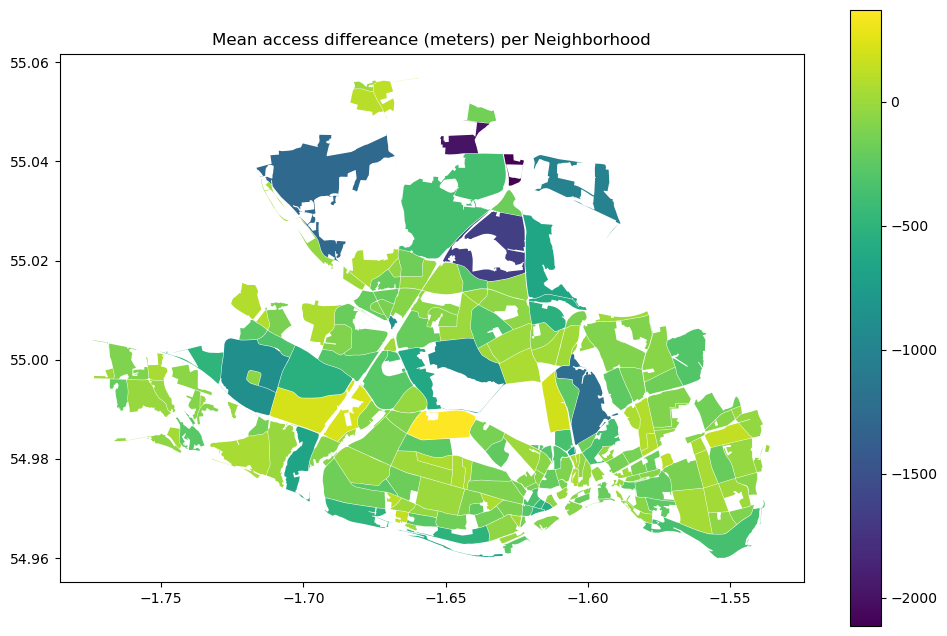

In [14]:
# Plot the map of total filter types
results_gdf.plot(column='mean_distance_diff', cmap='viridis', legend=True, figsize=(12, 8))
plt.title('Mean access differeance (meters) per Neighborhood')
plt.show()

In [15]:
results_gdf.explore(column='mean_distance_diff')